In [1]:
import pickle
from parameters.params import Params,Datasets,Models,Tasks
from util.env import set_param
from main import Main
import torch
from models.mine.MSTGAT import MSTGAT
from test_loop import test
from train_loop import train
import pandas as pd
from evaluate import IqrThreshold,MyConfusuion,IqrSensorThreshold,MinMaxThreshold,ZscoreThreshold

In [2]:
#board\my_mstgat_batadal\25_06_06_19_08_16
# snapshot\my_mstgat_batadal\25_06_06_21_32_18\0
path = "./snapshot/my_mstgat_batadal/25_06_06_21_32_18/0/"

param: Params = pickle.load(file=open(f"{path}param.pickle", "rb"))
param.summary()

'### ./snapshot/my_mstgat_batadal/25_06_06_21_32_18/0/best.pt\n\n#### Params\n\n     NO EXTRA PARAMETERS.\n\n\n\n     PARAMETERS :\n\n|   batch |  dataset  |   decay |  device  |   embedding_dimension |\n|---------|-----------|---------|----------|-----------------------|\n|      32 |  batadal  |       0 |   cuda   |                    32 |\n\n|   epoch |   learning_rate |   lstm_hidden_dim |   lstm_layers_num |   model   |\n|---------|-----------------|-------------------|-------------------|-----------|\n|      30 |           0.001 |                64 |                 1 | my_mstgat |\n\n|   out_layer_inter_dim |   out_layer_num |   random_seed |                    save_path                     |   stride |\n|-----------------------|-----------------|---------------|--------------------------------------------------|----------|\n|                    32 |               2 |             0 | ./snapshot/my_mstgat_batadal/25_06_06_21_32_18/0 |        1 |\n\n|    task    |   topk |   val_ra

In [3]:
param.val_ratio=0
set_param(param)

In [4]:
model_parameters=pickle.load(file=open( f"{path}model_parameters.pickle","rb"))

In [5]:
adj=torch.load(param.best_validationModel_path().replace("best.pt", "adj.pt"))

C:\Users\moji\AppData\Local\Temp\ipykernel_20084\1386274148.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adj=torch.load(param.best_validationModel_path().replace("bes

In [9]:
for row in adj2:
    l=[str( m) for m in row.int().tolist()]
    print("-".join(l))

1-0-0-0-0-0-0-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0
0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
0-0-0-1-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0
0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
0-0-0-0-0-0-1-0-0-0-0-0-0-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-1-0
1-0-0-0-0-0-0-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0
1-0-0-0-0-0-0-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0
0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
0-0-0-1-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0
0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0
0-0-0-0-0-0-1-0-0-0-0-0-0-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-

In [7]:
main = Main(param=param,modelParams=model_parameters,adj=adj)
adj1=main.model.adj


# DATASET 

*Datasets.batadal*
const:  S_PU1  =  0.0
const:  F_PU3  =  0.0
const:  S_PU3  =  0.0
const:  F_PU5  =  0.0
const:  S_PU5  =  0.0
const:  F_PU9  =  0.0
const:  S_PU9  =  0.0
#####################################
sensors count:  28
actuators count:  8
consts count:  7
consts:  ['S_PU1', 'F_PU3', 'S_PU3', 'F_PU5', 'S_PU5', 'F_PU9', 'S_PU9']
#####################################
#####################################
xlist: (36)
['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'F_PU2', 'F_PU4', 'F_PU6', 'F_PU7', 'F_PU8', 'F_PU10', 'F_PU11', 'F_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'S_PU2', 'S_PU4', 'S_PU6', 'S_PU7', 'S_PU8', 'S_PU10', 'S_PU11', 'S_V2']
#####################################
Model is trained. Loading from file .....


In [8]:
main.load_model(path=param.least_trainLossModel_path())
adj2:torch.Tensor=main.model.adj


In [ ]:
(main.model.adj).cpu().int()==adj.int()

In [10]:
print(len(main.train_dataloader),len(main.val_dataloader),len(main.test_dataloader))

274 0 131


## Train losses
get all losses from train data loader

In [11]:
train_all_loss,_,_ = test(main.model,main.train_dataloader,None)
train_all_loss.shape

torch.Size([8755, 36])

## Test losses

In [12]:
test_all_losses,ys,lbls = test(main.model, main.test_dataloader,confusion=None)


## IqrThreshold
From all losses get the threshold And confusion metrics.
Based onthe threshold and confusion, get the real output of test

In [ ]:
thr=IqrSensorThreshold()
thr.fit(train_all_loss)
conf=MyConfusuion(thr=thr).to(device=param.device)
print("test_all_losses.shape: ",test_all_losses.shape)
conf.update(test_all_losses,lbls)
confusion_matrix=conf.compute()
confusion_matrix

## MinMaxThreshold

In [ ]:

mmthr=MinMaxThreshold(multiplier=.95)
mmthr.fit(train_all_loss)
preds=mmthr.transform(test_all_losses)
mmConf=MyConfusuion(thr=mmthr).cuda()
mmConf.update(test_all_losses,lbls)
mmConf.compute()

<Axes: xlabel='m'>

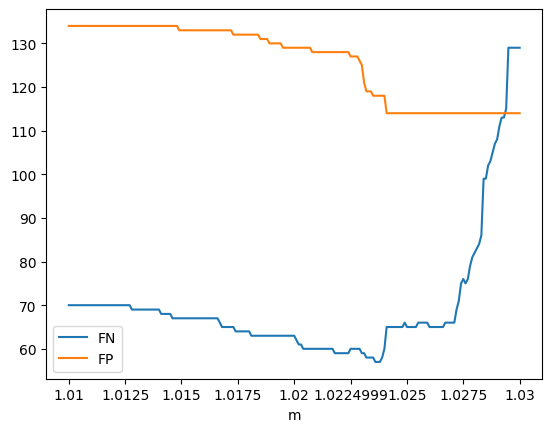

In [22]:
dft=pd.DataFrame({"FN":[],"FP":[],"m":[]})
for m in torch.arange(start=1.01,step=.0001,end=1.03):
    mxthr=MinMaxThreshold(multiplier=m)
    mxthr.fit(train_all_loss)
    mpreds=mxthr.transform(test_all_losses)
    mxConf=MyConfusuion(thr=mxthr).cuda()
    mxConf.update(test_all_losses,lbls)
    mtr=mxConf.compute().cpu().numpy()
    dft.loc[len(dft)]=[mtr[0][1],mtr[1][0],m.numpy()]
dft.plot(x="m")

In [ ]:
mmthr=ZscoreThreshold(threshold=3.42)
mmthr.fit(train_all_loss)
preds=mmthr.transform(test_all_losses)
mmConf=MyConfusuion(thr=mmthr).cuda()
mmConf.update(test_all_losses,lbls)
mmConf.compute()

In [ ]:
dft=pd.DataFrame({"FN":[],"FP":[],"m":[]})
for m in torch.arange(start=.8,step=.01,end=3.8):
    mxthr=ZscoreThreshold(threshold=m)
    mxthr.fit(train_all_loss)
    mpreds=mxthr.transform(test_all_losses)
    mxConf=MyConfusuion(thr=mxthr).cuda()
    mxConf.update(test_all_losses,lbls)
    mtr=mxConf.compute().cpu().numpy()
    dft.loc[len(dft)]=[mtr[0][1],mtr[1][0],m.numpy()]
dft.plot(x="m")

## AbsMaxThreshold

In [ ]:
from evaluate import AbsMaxThreshold
mmthr=AbsMaxThreshold(multiplier=3.7)
mmthr.fit(train_all_loss)
preds=mmthr.transform(test_all_losses)
mmConf=MyConfusuion(thr=mmthr).cuda()
mmConf.update(test_all_losses,lbls)
mmConf.compute()

In [ ]:

dft=pd.DataFrame({"FN":[],"FP":[]})
for m in torch.arange(start=.5,step=.1,end=5):
    mxthr=AbsMaxThreshold(multiplier=m)
    mxthr.fit(train_all_loss)
    mpreds=mxthr.transform(test_all_losses)
    mxConf=MyConfusuion(thr=mxthr).cuda()
    mxConf.update(test_all_losses,lbls)
    mtr=mxConf.compute().cpu().numpy()
    dft.loc[len(dft)]=[mtr[0][1],mtr[1][0]]
dft.plot()

In [23]:
# mmthr=IqrSensorThreshold()
mmthr=MinMaxThreshold(multiplier=1.025)
mmthr.fit(train_all_loss)
preds=mmthr.transform(test_all_losses)

## PLOTTING


all test Datasets

<Axes: >

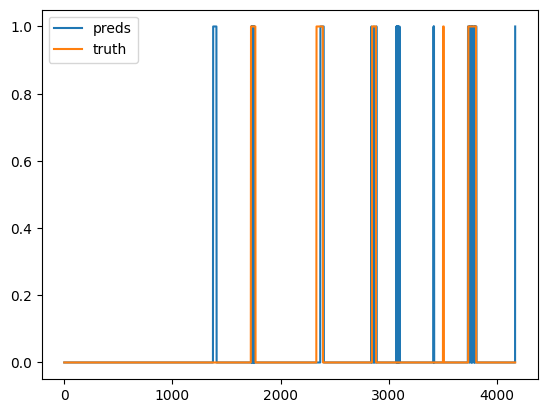

In [24]:

df=pd.DataFrame({"preds":preds.tolist(),"truth":lbls.tolist()})
df.plot()

Each attack zone


numebr of attacks =  219
First attack index is :  1726
Last attack index is :  3808
Number of attacks:  5
Minimum attack len:  6
Maximum attack len:  72
Mean attack len:  42.8


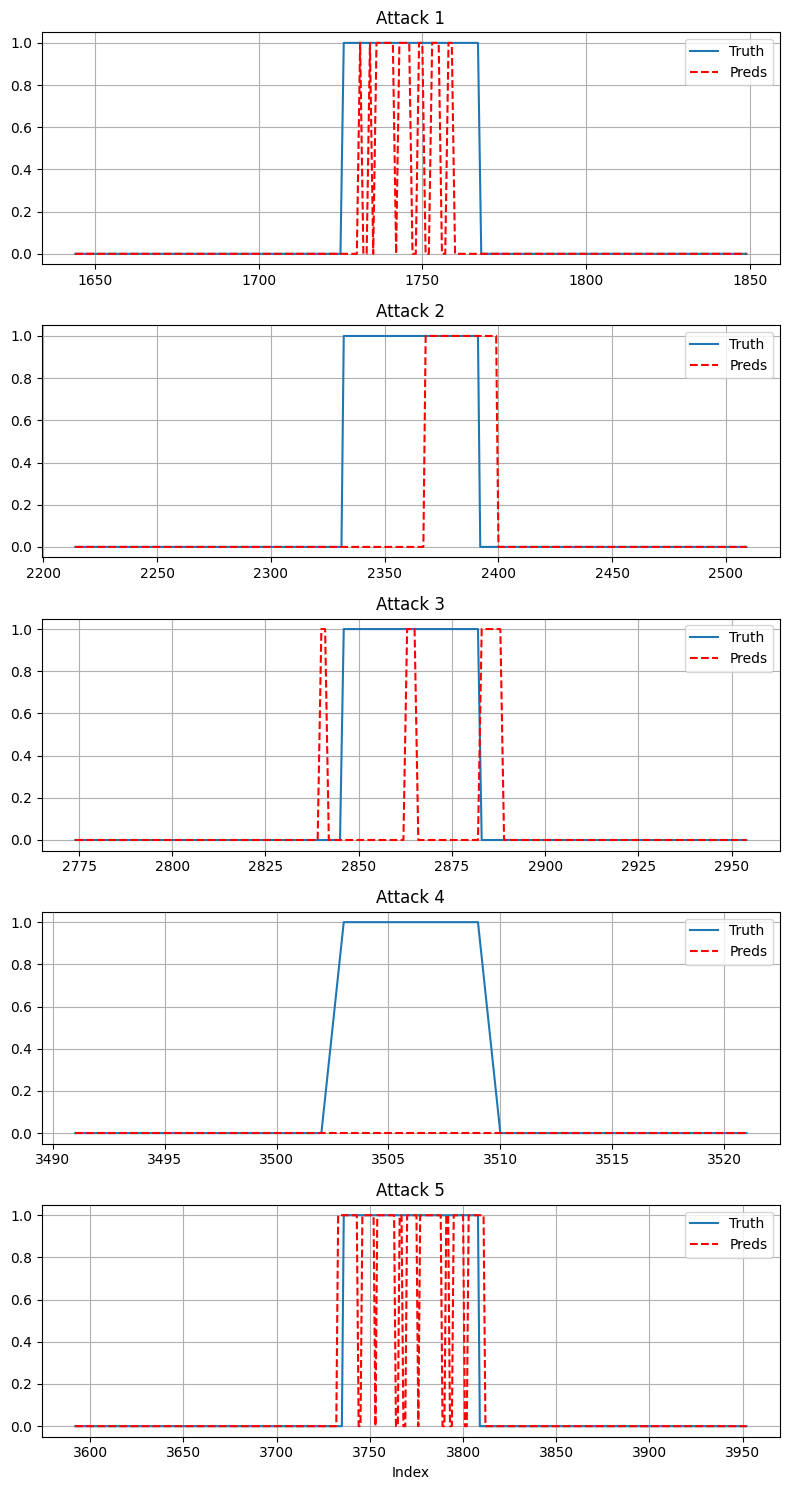

In [25]:
import matplotlib.pyplot as plt
from util.data import get_attack_interval,getAttacks


attacks=getAttacks(df,"truth")
# Identify contiguous regions of ones

# Create subplots dynamically
num_regions = len(attacks)
fig, axes = plt.subplots(num_regions, 1, figsize=(8, 3*num_regions), sharex=False)

if num_regions == 1:
    axes = [axes]  # Ensure axes is iterable

for i in range(num_regions):
    # first_idx = group.index.min()  # First occurrence of 1
    # last_idx = group.index.max()   # Last occurrence of 1
    [first_idx,last_idx]=attacks[i]
    range_before = first_idx - int(2.0 *(last_idx-first_idx))
    range_after = last_idx + int(2.0 *(last_idx-first_idx))
    if range_before<0:
        range_before=0
    if range_after>len(df):
        range_after=last_idx
    # df.iloc[first_idx:last_idx].plot(ax=ax)
    axes[i].plot( df.loc[range_before:range_after,'truth'], label="Truth")
    axes[i].plot( df.loc[range_before:range_after,'preds'], color='red', label="Preds",linestyle="--")

    # ax.set_xlim(range_before, range_after)  # X-axis limit dynamically adjusted
    # ax.set(ybound=(0, max(df['preds']) + 10))  # Corrected method for Y-axis limits

    axes[i].set_title(f"Attack {i+1}")
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel("Index")
plt.tight_layout()
plt.show()

In [ ]:
print("max: ",test_result[0].max(),
    #   val_result[0].max(),
      train_result[0].max())
print("min: ",test_result[0].min(),
    #   val_result[0].min(),
      train_result[0].min())


In [ ]:
from util.data import getAttacks

In [ ]:
minimum=0#val_result[0].min()
maximum=train_result[0].max().item()*1#*24.5

pred=torch.where((test_result[0]>maximum) ,torch.tensor(1),torch.tensor(0)).cpu().numpy()
labels_df=pd.DataFrame({"pred":pred,"truth":test_result[2].cpu().numpy()})
attacks=getAttacks(labels_df,"truth")


In [ ]:

for i,attack in enumerate(attacks):
    left=(attack[0]//100)*100
    right=((attack[1]//100)+1)*100
    labels_df.loc[left:right].plot(title=f"attack {i+1}")

In [ ]:
r=test_result[3].sum(-1)
print(r.max(),r.min(),r.mean())

In [ ]:
from evaluate import createMetrics
k=createMetrics(test_result,maximum)
print(k)
k.keys()

In [ ]:
k2=['TP', 'FP', 'TN', 'FN']
k1=["Accuracy","Precision","Recall","F1"]
d1={key:[] for key in k1}
d2={key:[] for key in k2}
x=[]
for i in range(100):
    _max=maximum*(.5+i/100)
    rr=createMetrics(test_result,_max)
    x.append(_max)
    for key  in d1.keys():
        d1[key].append(float(rr[key]))
    for key  in d2.keys():
        d2[key].append(float(rr[key]))